In [1]:
import os, random
import pingouin as pg
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm
from scipy.stats import spearmanr

Setting visualisation variables

In [2]:
sns.set("talk")
sns.set_style("whitegrid")

Coding_emotions = {
    "AN": "Anger",
    "AP": "Apprehension",
    "SD": "Sadness",
    "CO": "Confusion",
    "HA": "Happiness",
}

COLLECTION_order = [
    "Bea 1: a high school student", "Ed: dreams of his late wife", "Emma: 48 years of dreams",
    "Hall/VdC Norms: Female", "Hall/VdC Norms: Male", "Barb Sanders: baseline",
]

DF_idx_order = [
    "AN", "AP", "SD", "CO", "HA", "macro avg", "micro avg", "samples avg", "weighted avg"
]

metrics_clm = ["precision", "recall", "f1-score"]

DF_idx_print = (
    [('precision', 'General'),
    ('precision', 'Dreamer'),
    (   'recall', 'General'),
    (   'recall', 'Dreamer'),
    ( 'f1-score', 'General'),
    ( 'f1-score', 'Dreamer')],
           )

## K-fold Analysis

Read-in collected results

In [3]:
# General Emotions set
k_G_fold_results_df = pd.read_csv(
    "../Results/Kfold_results_General_bert-large-cased.csv", 
    sep=",",
)
k_G_fold_results_df["collection"]   = ["K-fold General"] * len(k_G_fold_results_df)
k_G_fold_results_df["Experiment"]   = ["K-fold General"] * len(k_G_fold_results_df)
k_G_fold_results_df["Emotions Set"] = ["General"] * len(k_G_fold_results_df)


# Dreamer Emotions set
k_D_fold_results_df = pd.read_csv(
    "../Results/Kfold_results_Dreamer_bert-large-cased.csv", 
    sep=",",
)

k_D_fold_results_df["collection"]   = ["K-fold Dreamer"] * len(k_D_fold_results_df)
k_D_fold_results_df["Experiment"]   = ["K-fold Dreamer"] * len(k_D_fold_results_df)
k_D_fold_results_df["Emotions Set"] = ["Dreamer"] * len(k_D_fold_results_df)


DF_mix = pd.concat([k_G_fold_results_df, k_D_fold_results_df])
DF_mix["Emotions"] = DF_mix.index

In [4]:
# Get mean and standard deviations (by fold)
k_G_mean = k_G_fold_results_df.groupby(k_G_fold_results_df.index).mean().round(0)
k_G_std  = k_G_fold_results_df.groupby(k_G_fold_results_df.index).std().round(0)

k_D_mean = k_D_fold_results_df.groupby(k_D_fold_results_df.index).mean().round(0)
k_D_std  = k_D_fold_results_df.groupby(k_D_fold_results_df.index).std().round(0)

In [5]:
DF_mix_mean = pd.concat([
    k_G_mean[metrics_clm], 
    k_D_mean[metrics_clm]], 
    axis=1, 
    keys=('General','Dreamer'),
)
DF_mix_mean.columns = DF_mix_mean.columns.swaplevel(0, 1)
DF_mix_mean.sort_index(axis=1, level=0, inplace=True)
DF_mix_mean = DF_mix_mean[metrics_clm]

DF_mix_std = pd.concat([
    k_G_std[metrics_clm], 
    k_D_std[metrics_clm]], 
    axis=1, 
    keys=('General','Dreamer'),
)
DF_mix_std.columns = DF_mix_std.columns.swaplevel(0, 1)
DF_mix_std.sort_index(axis=1, level=0, inplace=True)
DF_mix_std = DF_mix_std[metrics_clm]

In [6]:
Final_DF = DF_mix_mean.copy()
for clmn in DF_mix_mean.columns:
    for indx in DF_mix_mean.index:
        mean_v = DF_mix_mean.at[indx, clmn]
        std_v  = DF_mix_std.at[indx, clmn]
        Final_DF.at[indx, clmn] = "{} ± {}".format(mean_v, std_v)
        
Final_DF

precision                   recall                  f1-score  \
                  Dreamer     General      Dreamer      General      Dreamer   
AN             86.0 ± 9.0  85.0 ± 7.0   89.0 ± 3.0   89.0 ± 4.0   87.0 ± 4.0   
AP             86.0 ± 4.0  88.0 ± 7.0   88.0 ± 5.0   92.0 ± 3.0   87.0 ± 3.0   
CO             90.0 ± 5.0  92.0 ± 2.0   76.0 ± 6.0   85.0 ± 5.0   82.0 ± 5.0   
HA             93.0 ± 5.0  86.0 ± 4.0   85.0 ± 6.0   88.0 ± 3.0   89.0 ± 5.0   
SD            84.0 ± 10.0  84.0 ± 4.0  72.0 ± 15.0  77.0 ± 12.0  77.0 ± 11.0   
macro avg      88.0 ± 3.0  87.0 ± 3.0   82.0 ± 5.0   86.0 ± 2.0   85.0 ± 3.0   
micro avg      87.0 ± 3.0  87.0 ± 3.0   84.0 ± 4.0   87.0 ± 2.0   85.0 ± 3.0   
samples avg    88.0 ± 2.0  89.0 ± 2.0   87.0 ± 3.0   90.0 ± 2.0   86.0 ± 3.0   
weighted avg   88.0 ± 2.0  87.0 ± 4.0   84.0 ± 4.0   87.0 ± 2.0   85.0 ± 3.0   

                          
                 General  
AN            87.0 ± 5.0  
AP            89.0 ± 3.0  
CO            88.0 ± 3.0  
HA            87.0 ± 2.0  
SD            80.0 ± 7.0  
macro avg     86.0 ± 2.0  
micro avg     87.0 ± 2.0  
samples avg   88.0 ± 2.0  
weighted avg  87.0 ± 2.0

In [7]:
print(Final_DF.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{2}{l}{precision} & \multicolumn{2}{l}{recall} & \multicolumn{2}{l}{f1-score} \\
{} &      Dreamer &     General &      Dreamer &      General &      Dreamer &     General \\
\midrule
AN           &   86.0 ± 9.0 &  85.0 ± 7.0 &   89.0 ± 3.0 &   89.0 ± 4.0 &   87.0 ± 4.0 &  87.0 ± 5.0 \\
AP           &   86.0 ± 4.0 &  88.0 ± 7.0 &   88.0 ± 5.0 &   92.0 ± 3.0 &   87.0 ± 3.0 &  89.0 ± 3.0 \\
CO           &   90.0 ± 5.0 &  92.0 ± 2.0 &   76.0 ± 6.0 &   85.0 ± 5.0 &   82.0 ± 5.0 &  88.0 ± 3.0 \\
HA           &   93.0 ± 5.0 &  86.0 ± 4.0 &   85.0 ± 6.0 &   88.0 ± 3.0 &   89.0 ± 5.0 &  87.0 ± 2.0 \\
SD           &  84.0 ± 10.0 &  84.0 ± 4.0 &  72.0 ± 15.0 &  77.0 ± 12.0 &  77.0 ± 11.0 &  80.0 ± 7.0 \\
macro avg    &   88.0 ± 3.0 &  87.0 ± 3.0 &   82.0 ± 5.0 &   86.0 ± 2.0 &   85.0 ± 3.0 &  86.0 ± 2.0 \\
micro avg    &   87.0 ± 3.0 &  87.0 ± 3.0 &   84.0 ± 4.0 &   87.0 ± 2.0 &   85.0 ± 3.0 &  87.0 ± 2.0 \\
samples avg  &   88.0 ± 2.0 &  89.0 ±

/tmp/ipykernel_3273311/2636586414.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(Final_DF.to_latex())


/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


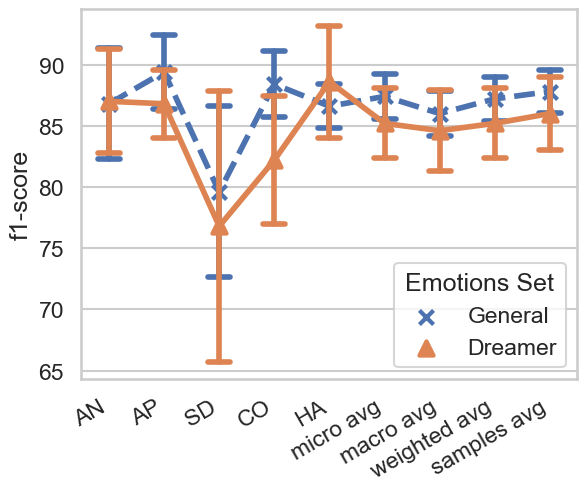

In [8]:
g = sns.pointplot(
    data=DF_mix, 
    x=DF_mix.index, 
    y="f1-score",
    hue="Emotions Set",
    linestyles=["--", "-"],
    markers=["x", "^"],
    errorbar=("sd", 1),
    capsize=.4, 
)

g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')
print()

## Ablation Analysis (General Emotions set)

Reading results in 

In [9]:
Ablation_DF = pd.read_csv(
    "../Results/Ablation_results_General_bert-large-cased.csv", 
)

Ablation_DF["Fold"] = ["Series"] * len(Ablation_DF)
Ablation_DF["Experiment"] = ["Ablation"] * len(Ablation_DF)
Ablation_DF["Series"]   = Ablation_DF["collection"]
Ablation_DF["Emotions"] = Ablation_DF.index

In [10]:
DF_mix = pd.concat([Ablation_DF, k_G_fold_results_df])
DF_mix["Emotions"] = DF_mix.index

Visualising single-Series results

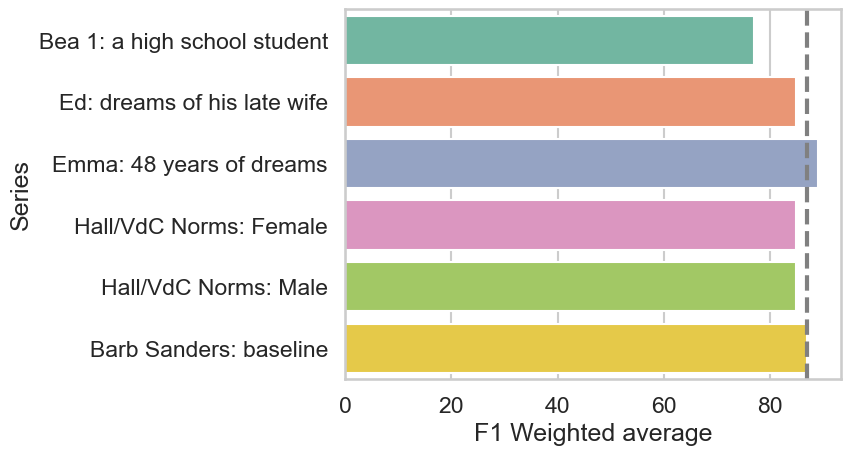

In [11]:
g = sns.barplot(
    data=Ablation_DF[["f1-score", "collection"]].loc["weighted avg"], 
    y="collection", 
    x="f1-score",
    palette="Set2",
    order=COLLECTION_order,
)

g.set_xlabel("F1 Weighted average"), g.set_ylabel("Series")
g.axvline(87, ls='--', color="gray", linewidth=3)
# g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right')

Break-down of sinlge Series-emotion performance 

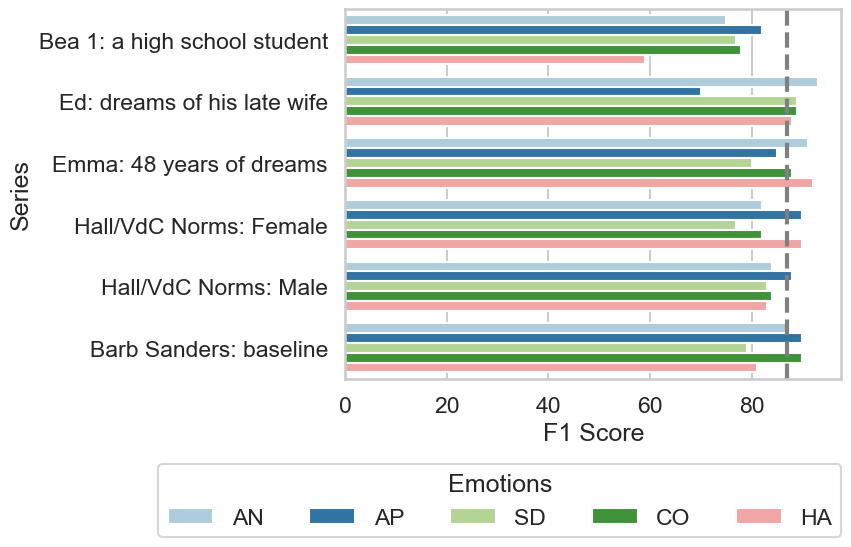

In [12]:
g = sns.barplot(
    data=Ablation_DF[Ablation_DF["Emotions"].isin(Coding_emotions.keys())], 
    hue="Emotions",
    x="f1-score",
    y="Series",
    order=COLLECTION_order,
    palette="Paired",
)

g.set_xlabel("F1 Score")
g.legend(title="Emotions", loc='center left', ncol=5, bbox_to_anchor=(-.4, -.33))
g.axvline(87, ls='--', color="gray", linewidth=3)

Group single-emotion performance (i.e., collapsign above results by Series).

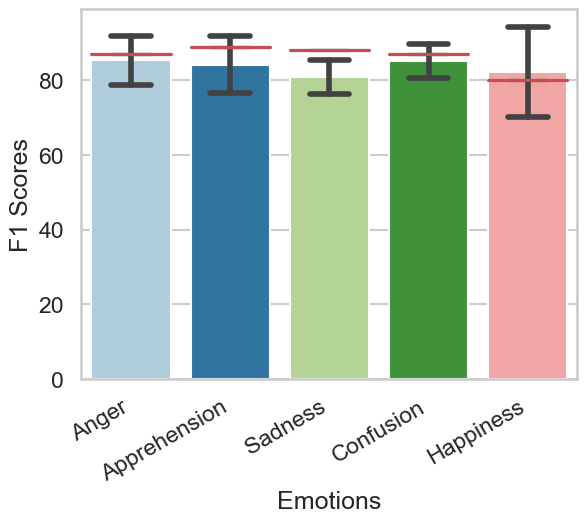

In [13]:
# average F1 scores for each emotion under the General Emotions set
emot_acr = pd.DataFrame.from_dict(
    {
    "Emotions":["AN", "AP", "SD", "CO", "HA"],
    "f1-score":[87, 89, 88, 87, 80]
    }
)

g = sns.barplot(
    data=Ablation_DF[Ablation_DF["Emotions"].isin(Coding_emotions.keys())], 
    x="Emotions",
    y="f1-score",
    palette="Paired",
    errorbar=("sd", 1),
    capsize=.4, 
    linewidth=1.5,
)

g = sns.boxplot(
    data=emot_acr, 
    x="Emotions",
    y="f1-score",
    medianprops={"color": "r"}
)
g.set_ylabel("F1 Scores")
g.set_xticklabels(list(Coding_emotions.values()), rotation=30, horizontalalignment='right')
print()

Run correlattion analysis between support (# items per emotion) and results (F1 score emotion) 

In [14]:
pvals = []
Series_Emot_Support_corr = []
for CLL in COLLECTION_order:
    lcl_df = Ablation_DF[
                Ablation_DF["Emotions"].isin(Coding_emotions.keys()) & 
                Ablation_DF["Series"].isin([CLL])
    ]
    rho, p = spearmanr(
        lcl_df["support"], 
        lcl_df["f1-score"]
    )
    pvals.append(p)
    Series_Emot_Support_corr.append([CLL, rho, p])

Series_Emot_Support_corr_df = pd.DataFrame(
                                Series_Emot_Support_corr, 
                                columns=["Series", "Spearman's \u03C1", "p"]
)

reject, pvals_corr = pg.multicomp(pvals, method='holm')
# print(reject, pvals_corr)
Series_Emot_Support_corr_df["Holm p"] = pvals_corr
Series_Emot_Support_corr_df

,Series,Spearman's ρ,p,Holm p
0,Bea 1: a high school student,0.300000,0.623838,0.623838
1,Ed: dreams of his late wife,-0.718185,0.171795,0.618474
2,Emma: 48 years of dreams,0.700000,0.188120,0.618474
3,Hall/VdC Norms: Female,0.790569,0.111367,0.556836
4,Hall/VdC Norms: Male,0.737865,0.154619,0.618474
5,Barb Sanders: baseline,0.820783,0.088587,0.531522


Print DataFrame (results table) as latex code

In [15]:
print(Series_Emot_Support_corr_df.round(4).to_latex())

\begin{tabular}{llrrr}
\toprule
{} &                        Series &  Spearman's ρ &       p &  Holm p \\
\midrule
0 &  Bea 1: a high school student &        0.3000 &  0.6238 &  0.6238 \\
1 &   Ed: dreams of his late wife &       -0.7182 &  0.1718 &  0.6185 \\
2 &      Emma: 48 years of dreams &        0.7000 &  0.1881 &  0.6185 \\
3 &        Hall/VdC Norms: Female &        0.7906 &  0.1114 &  0.5568 \\
4 &          Hall/VdC Norms: Male &        0.7379 &  0.1546 &  0.6185 \\
5 &        Barb Sanders: baseline &        0.8208 &  0.0886 &  0.5315 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3273311/3441893255.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(Series_Emot_Support_corr_df.round(4).to_latex())


Visualisation of the correlation analyss

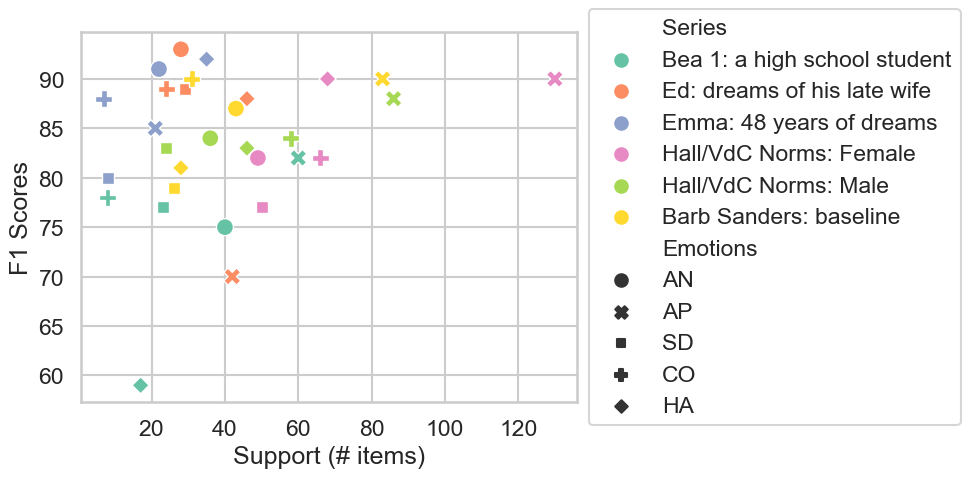

In [16]:
g = sns.scatterplot(
    data=Ablation_DF[Ablation_DF["Emotions"].isin(Coding_emotions.keys())], 
    x="support", 
    y="f1-score",
    style="Emotions",
    hue="Series",
    hue_order=COLLECTION_order,
    palette="Set2",
    s=150,
)

g.set_ylabel("F1 Scores"), g.set_xlabel("Support (# items)")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))